In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import Lasso,Ridge,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_validate
from sklearn.decomposition import PCA
from sklearn.metrics import auc,recall_score,precision_score,f1_score,roc_auc_score,make_scorer,roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor    
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
class data_util :
     #Constructor to save file paths
    def __init__(self, train_data , test_data) :
        self.train_data_path = self.check_file(train_data)
        self.test_data_path = self.check_file(test_data)
    
    #method to check if path is valid
    def check_file(self,path) :
        if os.path.isfile(path) :
            return path
        raise load_data_path + "does not exist"
    
    #Method to laod data
    def load_data(self) :
        self.train_data = pd.read_csv(self.train_data_path,
                                     names = ["target"]+["columns"+str(i) for i in range(1,97)])
        self.test_data = pd.read_csv(self.test_data_path,
                                    names = ["target"]+["columns"+str(i) for i in range(1,97)])
        
        print("Train data has {} rows and {} columns".format(self.train_data.shape[0],self.train_data.shape[1]))

        print("Test data has {} rows and {} columns".format(self.test_data.shape[0],self.test_data.shape[1]))
    
    #Check for missing values in columns 
    def check_missing(self) :
        for i in [(self.train_data,"Trainning data"),(self.test_data,"Testing data")] :
            missing_columnwise = i[0].isnull().sum(axis=0)
            missing_columnwise = missing_columnwise[missing_columnwise!=0]
            print("\n     "+i[1])
            print("\nNumber of Columns with missing values: "+str(len(missing_columnwise)))
            print("Columns with missing values: "+" ".join(missing_columnwise))
    
    #check for Zero Variance columns 
    def zero_varinace(self) :
        for i in [(self.train_data,"Trainning data"),(self.test_data,"Testing data")] :
            zero_variance_col = i[0].apply(lambda x : x.var() == 0 ,axis=0).sum()
            print("\n     "+i[1])
            print("Columns with Zero variance: "+str(zero_variance_col))
    
    def check_correlation(self):
        #combine test and train and get coorelation matrix
        panel = pd.concat([self.train_data,self.test_data])        
        panel = panel.drop(["target"],axis=1).corr(method='pearson').abs()
        panel = panel.unstack().reset_index()
        panel.columns = ["Col1","Col2","Corr"]
        panel = panel[~(panel["Col1"] == panel["Col2"])]
        panel = panel[panel["Corr"] > 0.99]
        
        panel["Pairs"] = panel.apply(lambda x : sorted([x["Col1"],x["Col2"]]),axis=1)
        print("Sample Correlated pairs: ")
        print(panel.head())
        print(" Pairs with correlation greater than 0.99: "+str(len(np.unique(panel["Pairs"]))))
    
    def VIF(self, thresh=5.0):
        train_data_ = self.train_data.drop(["target"],axis=1)
        dropped_columns = []
        columns = list(range(train_data_.shape[1]))
        removed = True
        while removed:
            removed = False
            vif = [variance_inflation_factor(train_data_.iloc[:, columns].values, ix)
                   for ix in range(train_data_.iloc[:, columns].shape[1])]

            top_loc = vif.index(max(vif))
            if max(vif) > thresh:
                #print('Dropping \'' + train_data_.iloc[:, columns].columns[top_loc] )
                dropped_columns.append(train_data_.iloc[:, columns].columns[top_loc])
                del columns[top_loc]
                removed = True

        print("Dropped Following Columns: "+ ", ".join(dropped_columns))
        print('Final remainning variables:')
        print(train_data_.columns[columns])
        #columns.append("target")
        return train_data_.iloc[:, columns]
        
        

In [3]:
data  = data_util(train_data="../modeling/test2_modeling/interview_data/interview_data_train.csv",
                 test_data = "../modeling/test2_modeling/interview_data/interview_data_test.csv")

In [4]:
data.load_data()

Train data has 27914 rows and 97 columns
Test data has 13834 rows and 97 columns


In [5]:
#checking for missing values
data.check_missing()


     Trainning data

Number of Columns with missing values: 0
Columns with missing values: 

     Testing data

Number of Columns with missing values: 0
Columns with missing values: 


In [6]:
#check for zero varaince columns(columns with single value)
data.zero_varinace()


     Trainning data
Columns with Zero variance: 0

     Testing data
Columns with Zero variance: 0


In [7]:
data.check_correlation()

Sample Correlated pairs: 
         Col1       Col2      Corr                  Pairs
17   columns1  columns18  0.999989  [columns1, columns18]
583  columns7   columns8  0.997114   [columns7, columns8]
584  columns7   columns9  0.999997   [columns7, columns9]
585  columns7  columns10  0.999997  [columns10, columns7]
586  columns7  columns11  0.997114  [columns11, columns7]
 Pairs with correlation greater than 0.99: 140


In [8]:
#calculating the variance inflation factor for each variable and deleting the variable with highest VIF value
#looping this process till we have no variable crossing the threshold value(5.0)
train_data = data.VIF()
train_data["target"] = data.train_data["target"]

Dropped Following Columns: columns8, columns9, columns13, columns14, columns20, columns21, columns23, columns24, columns25, columns26, columns27, columns29, columns30, columns31, columns32, columns42, columns43, columns44, columns47, columns48, columns49, columns53, columns56, columns57, columns58, columns64, columns67, columns74, columns77, columns80, columns83, columns86, columns95, columns81, columns10, columns63, columns15, columns18, columns65, columns89, columns78, columns59, columns72, columns76, columns61, columns90, columns66, columns68, columns55, columns87, columns84, columns51, columns46, columns16, columns11, columns62, columns82, columns75, columns71, columns73, columns34, columns50, columns54, columns88, columns28, columns35, columns37, columns85, columns22, columns17, columns79, columns33, columns7, columns60, columns12, columns2, columns1, columns70
Final remainning variables:
Index(['columns3', 'columns4', 'columns5', 'columns6', 'columns19',
       'columns36', 'colu

In [9]:
train_data.head()

,columns3,columns4,columns5,columns6,columns19,columns36,columns38,columns39,columns40,columns41,columns45,columns52,columns69,columns91,columns92,columns93,columns94,columns96,target
0,0.098759,-0.505371,0.167896,0.538775,-0.175995,-0.050936,0.225517,0.091388,0.059398,0.029805,-0.166607,0.115629,-0.415062,-0.207339,-0.188567,-0.027453,0.065762,-0.153453,0
1,0.098759,-0.505371,0.167896,0.538775,-0.175995,-0.050936,0.225517,0.091388,0.059398,0.029805,-0.166607,0.115629,-0.415062,-0.207339,-0.188567,-0.027453,0.065762,-0.153453,0
2,0.098759,-0.505371,0.167896,0.538775,-0.175995,-0.050936,0.225517,0.091388,0.059398,0.029805,-0.166607,0.115629,-0.415062,-0.207339,-0.188567,-0.027453,0.065762,-0.153453,0
3,0.098759,-0.505371,-0.500919,-0.671476,-0.175995,-0.050936,-0.150621,-0.899191,-1.058576,-1.190347,-0.166607,-0.231834,-0.415062,-0.207339,-0.188567,-0.027453,-0.948990,-0.153453,0
4,0.098759,-0.505371,-0.500919,0.384008,-0.175995,-0.050936,-0.150621,-0.899191,-1.058576,-1.190347,-0.166607,-0.231834,-0.415062,-0.207339,-0.188567,-0.027453,-0.948990,-0.153453,0


### Exploratory Data Analysis

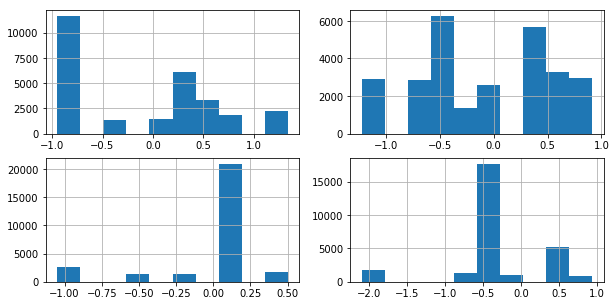

In [10]:
#Distributions 
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,5))
train_data["columns94"].hist(ax=ax[0][0])
train_data["columns6"].hist(ax=ax[0][1])
train_data["columns3"].hist(ax=ax[1][0])
train_data["columns69"].hist(ax=ax[1][1])

(0, 20000)

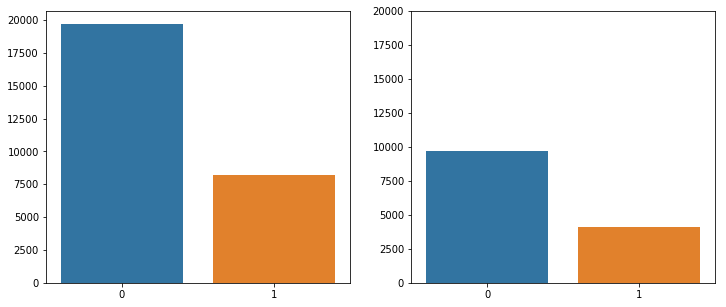

In [11]:
# Target Variable in trainning and test data. Looks like target variable is in same proportions in both datasets
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))

train_target = train_data["target"].value_counts()
sns.barplot(x = train_target.index,y=train_target.values,orient='v' ,ax=ax[0])
test_target = data.test_data["target"].value_counts()
sns.barplot(x = test_target.index,y=test_target.values,orient='v' ,ax=ax[1])
ax[1].set_ylim(0,20000)

### Modeling 

In [12]:
X_train = train_data.drop(['target'],axis=1)
Y_train = train_data["target"]

X_test = data.test_data[X_train.columns]
Y_test = data.test_data["target"]

#### Logistic regression

In [13]:
# Building logistic regression with L1 regularization. Using cross validation to get the AUC score 
LR = LogisticRegression(penalty="l2")

cross_val_score(LR,X_train,Y_train,cv=2,scoring = 'roc_auc').mean()

0.7768190141176661

#### Random forest

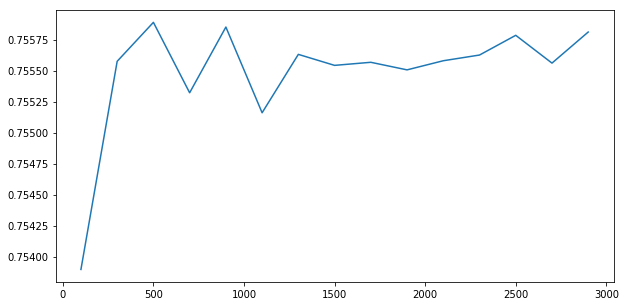

In [14]:
# Tunning the number of trees 
rf_score = []
for estimators in range(100,3000,200) :
    rf = RandomForestClassifier(n_estimators = estimators,n_jobs=-1)
    rf_score.append(cross_val_score(rf,X_train,Y_train,cv=3,scoring = 'roc_auc').mean())

fig = plt.figure(figsize=(10,5))
plt.plot(range(100,3000,200),rf_score)

In [15]:
#Building a GBM Model 
#GridSearchCV to get optimal values for tree-based parameters 
#fixing learning rate to be 0.1 and estimators to be 40 and max_features to be sqrt

gbm  = GradientBoostingClassifier()

param_test1 = {'max_depth':range(5,16,2),
               'min_samples_split':range(200,1001,200),
               'min_samples_leaf':range(30,71,10),
              }


gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,n_estimators = 50,
                                                               min_samples_split=500,min_samples_leaf=50,
                                                               max_depth=8,max_features='sqrt',
                                                               subsample=0.8,random_state=10),
                        param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=3)

gsearch1.fit(X_train,Y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 13, 'min_samples_leaf': 60, 'min_samples_split': 600},
 0.7938610270563237)

CV Score : Mean - 0.7961299 | Std - 0.02967821 | Min - 0.7634603 | Max - 0.8401473


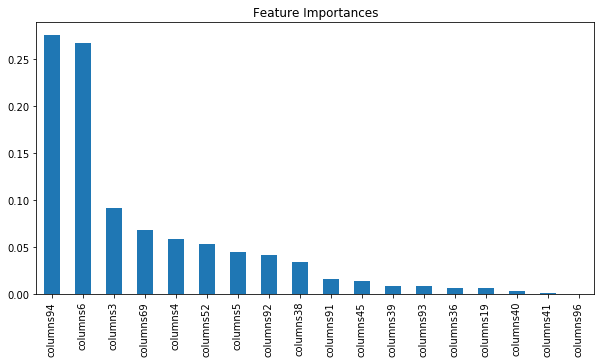

In [16]:
# We get the optimal values as 
# max_depth = 13
# min_samples_split = 600
# min_samples_leaf = 60
#Now decreasing the learning_rate and increasing the n_estimators

gbm_tuned = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1200,
                                         max_depth=13, min_samples_split=600,min_samples_leaf=60,
                                         subsample=0.85,random_state=10,max_features='sqrt')

gbm_tuned.fit(X_train,Y_train)
    
#Perform cross-validation:
cv_score = cross_val_score(gbm_tuned, X_train,Y_train, cv=5, scoring='roc_auc')
    
print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
#Print Feature Importance:
fig = plt.figure(figsize=(10,5))
feat_imp = pd.Series(gbm_tuned.feature_importances_,X_train.columns ).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')


### Model Evaluation 

In [51]:
def roc_curve_plot(model,X_train,Y_train) :
    prob = model.predict_proba(X_train)
    preds = prob[:,1]
    fpr, tpr, threshold = roc_curve(Y_train, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate(TPR)')
    plt.xlabel('False Positive Rate(FPR)')
    plt.show()

In [54]:
def model_evaluation(model,X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test) :
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    print("Training data score: ")
    probs = model.predict_proba(X_train)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(Y_train, preds)
    roc_auc = auc(fpr, tpr)
    print("AUC: "+str(roc_auc)+"    Recall: "+str(recall_score(Y_train,train_pred))+
          "    F1-score: "+str(f1_score(Y_train,train_pred)))
    print("Test data score:")
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    print("AUC: "+str(roc_auc)+"    Recall: "+str(recall_score(Y_test,test_pred))+
          "    F1-score: "+str(f1_score(Y_test,test_pred)))


In [55]:
LR = LogisticRegression(penalty="l1")

LR.fit(X_train,Y_train)

model_evaluation(LR) #best linear model with not much difference in trainning and test score 

Training data score: 
AUC: 0.7864013461331871    Recall: 0.4331140350877193    F1-score: 0.5161899230434152
Test data score:
AUC: 0.7810285021639357    Recall: 0.41721371261852663    F1-score: 0.5040387722132472


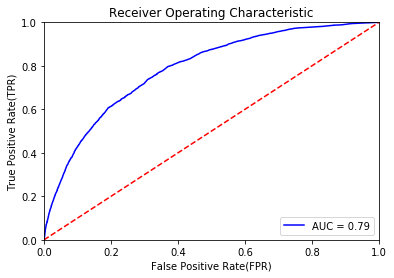

In [57]:
roc_curve_plot(LR,X_train,Y_train)

In [58]:
rf = RandomForestClassifier(n_estimators = 700,n_jobs=-1)

rf.fit(X_train,Y_train)

model_evaluation(rf) #Clearly we are ovverfitting here as trainning AUC is way higher than test 

Training data score: 
AUC: 0.9040346739863518    Recall: 0.6191520467836257    F1-score: 0.7002411298656562
Test data score:
AUC: 0.771514871028613    Recall: 0.4400680768295648    F1-score: 0.512022630834512


In [59]:
gbm = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1200,
                                         max_depth=13, min_samples_split=600,min_samples_leaf=60,
                                         subsample=0.85,random_state=10,max_features='sqrt')
gbm.fit(X_train,Y_train)

model_evaluation(gbm) #best model with 0.79 AUC

Training data score: 
AUC: 0.8249484033222088    Recall: 0.49171539961013644    F1-score: 0.5694532627865961
Test data score:
AUC: 0.7983078735524939    Recall: 0.45198152200340386    F1-score: 0.5292526690391458


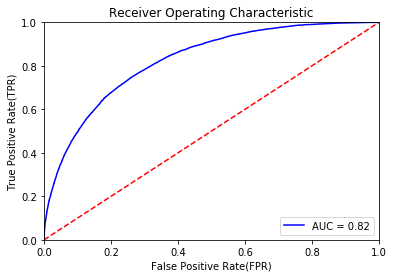

In [60]:
roc_curve_plot(gbm,X_train,Y_train)

### Feature Importance

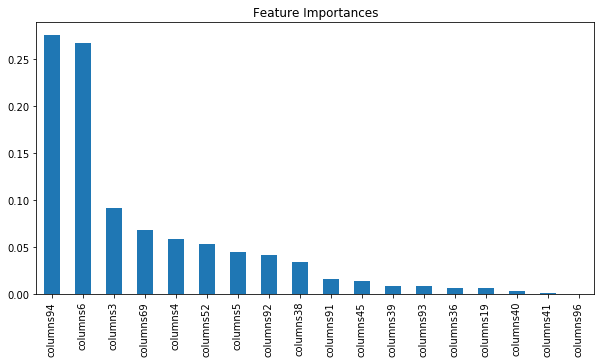

In [61]:
fig = plt.figure(figsize=(10,5))
feat_imp = pd.Series(gbm.feature_importances_,X_train.columns ).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

### Column94 

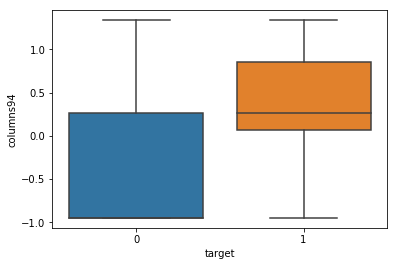

In [62]:
# we can clearly see the difference in distribution of data for two classes. Values less the 0 tends to be class"0" 
sns.boxplot(x="target",y="columns94",data=train_data)

### Column 6

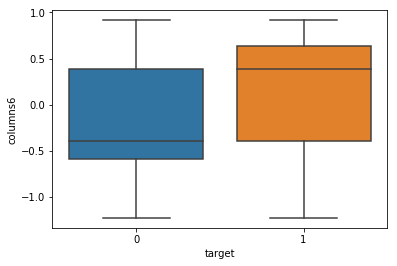

In [63]:
# datapoints with value greater than 0.5 tend to be class "1". As we have imblanaced data, features which can identify
# even small portion of class "1" is given more importance
sns.boxplot(x="target",y="columns6",data=train_data)

### Next Steps

#### Try using PCA to reduce the feature but this will loose interpretability of model
#### use advanced models like Xgboost with parameter tunning to improve the model performance 
#### use packages like LIME and SHAP to understand the model and impact of features on target variable